In [1]:
import pandas as pd
import spacy

### Import reviews Pennsylvania, pos, neg, neutral

In [ ]:
reviews = pd.read_csv('data/review_pa_sentiment.csv')

In [ ]:
reviews[['sentiment_label', 'sentiment_score']] = reviews['result'].str.split(', ', expand=True)
reviews[['delete', 'sentiment_label']] = reviews['sentiment_label'].str.split(' ', expand=True)

In [ ]:
reviews['sentiment_label'] = reviews['sentiment_label'].str.replace('LABEL_2', 'Positive')
reviews['sentiment_label'] = reviews['sentiment_label'].str.replace('LABEL_1', 'Neutral')
reviews['sentiment_label'] = reviews['sentiment_label'].str.replace('LABEL_0', 'Negative')
reviews['sentiment_label'] = reviews['sentiment_label'].str.replace("'", "")

In [ ]:
reviews.drop(columns=['delete', 'result', 'sentiment_score'], inplace=True, errors='ignore')

In [ ]:
neg_reviews = reviews[reviews['sentiment_label'] == 'Negative']

In [ ]:
neg_reviews

In [ ]:
reviews_list = []

for review in neg_reviews['text'][:1500]:
    reviews_list.append(review)

reviews_text = ', '.join(reviews_list)

In [ ]:
reviews_text = reviews_text.lower()

### Import negative reviews 3.5 stars, Pennsylvania

In [2]:
reviews = pd.read_csv('data/biz_review_ 3-5.csv')

In [3]:
reviews_list = []

for review in reviews['text'][:1500]:
    reviews_list.append(review)

reviews_text = ', '.join(reviews_list)

In [8]:
reviews_text = reviews_text.lower()

In [9]:
reviews_text

'their eggplant parm is terrible. eggplant wasn\'t cooked right so it was chewy disgusting. greek caesar salad looked great except lettuce all wilted cause they didn\'t refrigerate. too many other places to go before revisiting, just had this pizza for the first time, and i\'d say it is some of the worst i\'ve eaten. it reminds me of cafeteria pizza. i\'m sticking with felicia\'s pizza around the corner., i ordered take-out...and i regreted quickly! i ordered online and not in store so perhaps that  was a huge mistake. i like carmelized onions and roasted eggplant on my pizza - what i\'ve got was about 3 pounds of eggplant parmegiana on top of my pizza instead. the pizza was 3" high. way too much stuff which left the dough gooey and raw! \nnever again!, we ordered a delivery online through eat street, ardmore pizza confirmed the order online, we received the confirmation email, but the food did not come. we called and they lied about receiving the order, and did nothing to help other t

### Prepare food labels to train entity ruler. Train entity ruler

In [ ]:
# Training the entity rule to recognize food

food_df = pd.read_csv('data/food_labels.csv')

In [ ]:
food_labels = food_df[food_df['description'].str.contains('[a-zA-Z]') == True]['description']

In [ ]:
food_labels = food_labels[food_labels.str.split().apply(len) <= 2].drop_duplicates()

In [ ]:
food_labels = food_labels.str.lower()

In [ ]:
food_labels = food_labels[food_labels.str.contains('.*,.*,.*', regex=True) == False]

In [ ]:
# Fix: Foods are comma seperated and order is reversed: 'muffins, blueberry' become 'blueberry muffins'

food_labels[food_labels.str.contains(', ') == True] = (
    food_labels[food_labels.str.contains(', ') == True].str.split(', ', expand=True)[1] +
    ' ' +
    food_labels[food_labels.str.contains(', ') == True].str.split(', ', expand=True)[0]
)

food_labels[food_labels.str.contains(',') == True] = (
    food_labels[food_labels.str.contains(',') == True].str.split(',', expand=True)[1] +
    ' ' +
    food_labels[food_labels.str.contains(',') == True].str.split(',', expand=True)[0]
)

In [ ]:
# If label has no plural, create singular form. If label has no singular, create plural 

import lemminflect

nlp = spacy.load('en_core_web_lg')

inflected_labels = []

for label in food_labels:
    
    doc = nlp(label)

    if len(doc) == 1:
        if doc[0].tag_ == 'NNS':
            inflected_labels.append(doc[0]._.inflect('NN'))
        else:
            inflected_labels.append(doc[0]._.inflect('NNS'))

    if len(doc) == 2:
        if doc[1].tag_ == 'NNS':
            inflected_labels.append(doc[0].text + ' ' + doc[1]._.inflect('NN'))
        else:
            inflected_labels.append(doc[0].text + ' ' + doc[1]._.inflect('NNS'))

In [ ]:
food_labels_inflected = pd.Series(inflected_labels)

In [ ]:
food_labels = pd.concat([food_labels, food_labels_inflected])

In [ ]:
food_labels.drop_duplicates(inplace=True)

In [ ]:
food_labels[food_labels.str.contains('bar', regex=True)]

In [ ]:
# Add food labels to entity ruler

food_labels = food_labels  # Remove 'bar' from foods_labels, add 'product'

patterns = []

nlp = spacy.load('en_core_web_lg')

ruler = nlp.add_pipe('entity_ruler', before='ner')

for label in food_labels:
    patterns.append({'label': 'FOOD', 'pattern': label})

ruler.add_patterns(patterns)

In [ ]:
len(patterns)

In [ ]:
ruler.to_disk('data/food_patterns.jsonl')

In [10]:
nlp = spacy.load('en_core_web_lg')

ruler = nlp.add_pipe("entity_ruler")

ruler.from_disk('data/food_patterns.jsonl')

### Use matcher to analyse text

In [11]:
# Use this when working on a batch. Runs faster

import spacy
from spacy.matcher import Matcher

# nlp = spacy.load('en_core_web_lg')  # !!!Do not load again, because will reset the modified entity ruler from above

matcher = Matcher(nlp.vocab)

pattern = [
    [
        {'ENT_TYPE': 'FOOD'},
        {'LEMMA': {'IN': ['be', 'taste', 'smell']}},
        {'DEP': 'neg', 'OP': '?'},
        {'POS': 'ADV', 'OP': '?'},
        {'POS': 'ADJ'}
    ]#,
    # [
    #     # {'POS': 'ADJ'},
    #     {'ENT_TYPE': 'FOOD'}
    # ]  
]
matcher.add('FOOD_IS', pattern, greedy='LONGEST')

# doc=nlp(reviews_text)


doc=nlp(reviews_text)
matches = matcher(doc)

# Create list of top ten adjectives that were used to describe the food
# Show as a word cloud

In [13]:
type(matches)

list

In [ ]:
# Use this one for all of the reviews

from spacy.matcher import Matcher

matcher = Matcher(nlp.vocab)

pattern = [
    [
        {'ENT_TYPE': 'FOOD'},
        {'LEMMA': {'IN': ['be', 'taste', 'smell']}},
        {'DEP': 'neg', 'OP': '?'},
        {'POS': 'ADV', 'OP': '?'},
        {'POS': 'ADJ'}
    ]
]

matcher.add('FOOD_IS', pattern, greedy='LONGEST')

for text in reviews_text:
    doc=nlp(text)
    matches = matcher(doc)


In [ ]:
matches

In [ ]:
list_matches = []

for match in matches:
    list_matches.append(doc[match[1]:match[2]].text)

adjectives = ', '.join(list_matches)
adjectives = adjectives.replace('n\'t', 'not')#.replace('wasnot', 'was not')

adjectives

In [ ]:
import spacy
from spacy.matcher import Matcher

# nlp = spacy.load('en_core_web_lg')  # !!!Do not load again, because will reset the modified entity ruler from above

matcher = Matcher(nlp.vocab)

pattern = [
    [
        {'DEP': 'neg', 'OP': '?'},
        {'POS': 'ADV', 'OP': '?'},
        {'POS': 'ADJ'}
    ]
]
matcher.add('FOOD_IS', pattern, greedy='LONGEST')

# doc=nlp(reviews_text)
doc=nlp(adjectives)
matches = matcher(doc)

# Create list of top ten adjecties that were used to describe the food
# Show as a word cloud

In [ ]:
print(len(matches))
for match in matches:
    print(match, doc[match[1]:match[2]])

In [22]:
list_matches = []

for match in matches:
    list_matches.append(doc[match[1]:match[2]].text)

# adjectives = ', '.join(list_matches)

len(list_matches)

798

In [23]:
word_frequencies = {}

for item in list_matches:
    if item not in word_frequencies:
        word_frequencies[item] = 1
    else:
        word_frequencies[item] += 1

In [24]:
word_frequencies

{"beer wasn't very good": 1,
 "sauce wasn't much better": 1,
 "slice wasn't very good": 1,
 'sushi is not as fresh': 1,
 "beer isn't much better": 1,
 "salad isn't very good": 1,
 "chicken wasn't very good": 1,
 'salad was not much better': 1,
 "food isn't that good": 1,
 'food is not exactly cheap': 1,
 "crepes aren't very good": 1,
 'food is not as good': 1,
 'food was not very good': 1,
 "sushi isn't so bad": 1,
 'ramen was not very good': 1,
 'soup was not very successful': 1,
 "rice wasn't even good": 1,
 "food wasn't very good": 1,
 "food wasn't so good": 1,
 'wings were not as flavorful': 1,
 'sauce was not very good': 1,
 'food was not very exciting': 1,
 'pizza is now equal': 1,
 'pizza was no better': 1,
 'sandwich was not great': 1,
 'pizza was not authentic': 1,
 'pizza is very comparable': 1,
 'food is consistently good': 1,
 'drinks were all right': 1,
 'food is just bad': 1,
 'bagel was pretty bad': 1,
 'bagel was pretty good': 1,
 'bagel was completely flavorless': 1,
 

In [25]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

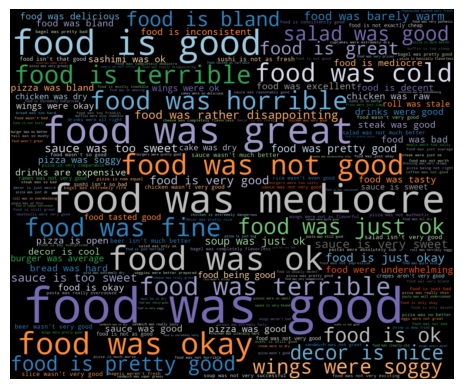

In [27]:
wordcloud = WordCloud(width=1200, height=1000, prefer_horizontal=1.5, colormap='tab20c')

stopwords = {'good', 'great', 'decent', 'pretty good', 'very good', 'ok', 'okay', 'tasty', 'fine', 'nice'}

filtered_word_frequencies = {word: freq for word, freq in word_frequencies.items() if word not in stopwords}

wordcloud.fit_words(filtered_word_frequencies)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
import seaborn as sns

In [ ]:
labels_df = pd.DataFrame({'matched_labels': list_matches})

In [ ]:
labels_df.value_counts().head(20)

In [ ]:
fig, ax = plt.subplots(figsize=(40, 5))

sns.barplot(x=list(filtered_word_frequencies.keys()), y=list(filtered_word_frequencies.values()));

In [ ]:
import spacy
from spacy.matcher import Matcher

# nlp = spacy.load('en_core_web_lg')  # !!!Do not load again, because will reset the modified entity ruler from above

matcher = Matcher(nlp.vocab)

pattern = [
    [
        {'ENT_TYPE': 'FOOD'},
        {'LEMMA': {'IN': ['be', 'taste', 'smell']}},
        # {'DEP': 'neg', 'OP': '?'},
        # {'POS': 'ADV', 'OP': '?'},
        # {'POS': 'ADJ'},
        {'TEXT': 'good'},
        {'TEXT': 'but'}

    ]#,
    # [
    #     # {'POS': 'ADJ'},
    #     {'ENT_TYPE': 'FOOD'}
    # ]  
]
matcher.add('FOOD_IS', pattern, greedy='LONGEST')

# doc=nlp(reviews_text)
doc=nlp(reviews_text)
matches_t = matcher(doc)

# Create list of top ten adjectives that were used to describe the food
# Show as a word cloud

In [ ]:
print(len(matches_t))

for match in matches_t:
    print(match, doc[match[1]-10:match[2]+10])